## Library Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import f1racing.helper as f1_helper
import math

## Data 

In [2]:
# Copy EDA notebook code here to get initial dataset to do transformations on
current_dir = os.getcwd()
f1sim_df = pd.read_csv(os.path.join(current_dir, '..', 'processed_data', 'f1sim_combined.csv'))

f1sim_left = pd.read_csv(os.path.join(current_dir, '..', 'data', 'f1sim-ref-left.csv'))
f1sim_right = pd.read_csv(os.path.join(current_dir, '..', 'data', 'f1sim-ref-right.csv'))

f1sim_line = pd.read_csv(os.path.join(current_dir, '..', 'data', 'f1sim-ref-line.csv'))
f1sim_turns = pd.read_csv(os.path.join(current_dir, '..', 'data', 'f1sim-ref-turns.csv'))

In [3]:
f1sim_df = f1sim_df.drop(['Unnamed: 0'], axis=1)
f1sim_df = f1sim_df.reset_index(drop=True)

## Feature Transformations

### Lap Validity

In [4]:
f1sim_left_df = f1sim_left.sort_values("FRAME").reset_index(drop=True)
# Select only the required columns and drop duplicates
f1sim_left_df = f1sim_left_df[["WORLDPOSX", "WORLDPOSY"]].drop_duplicates()

# Filter rows with the corrected coordinates that lie between the start line and midpoint of Turn 2 and Turn 3
f1sim_left_df = f1sim_left_df[
    (f1sim_left_df["WORLDPOSX"] <= 551) & 
    (f1sim_left_df["WORLDPOSX"] >= 100) & 
    (f1sim_left_df["WORLDPOSY"] <= 500) & 
    (f1sim_left_df["WORLDPOSY"] >= -500)
]

# cut off left and right reference line 

f1sim_right_df = f1sim_right.sort_values("FRAME").reset_index(drop=True)
f1sim_right_df = f1sim_right[["WORLDPOSX", "WORLDPOSY"]].drop_duplicates()

f1sim_right_df = f1sim_right_df[
    (f1sim_right_df["WORLDPOSX"] <= 551) & 
    (f1sim_right_df["WORLDPOSX"] >= 100) & 
    (f1sim_right_df["WORLDPOSY"] <= 500) & 
    (f1sim_right_df["WORLDPOSY"] >= -500)
]

f1sim_df = f1sim_df[
    (f1sim_df["WORLDPOSX"] <= 551) & 
    (f1sim_df["WORLDPOSX"] >= 100) & 
    (f1sim_df["WORLDPOSY"] <= 500) & 
    (f1sim_df["WORLDPOSY"] >= -500)
]
f1sim_df.reset_index(drop=True)

,SESSION_IDENTIFIER,FRAME,LAP_NUM,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SPEED_KPH,THROTTLE,BRAKE,STEERING,WORLDPOSX,WORLDPOSY,LAP_ID
0,1.004645e+19,1652,1,0.580389,0,289.0,0.998413,0.0,0.002243,111.150146,464.910126,1.0046447013921722e+19_1
1,1.004645e+19,1653,1,4.607213,50,290.0,0.998413,0.0,0.001144,114.049080,462.116333,1.0046447013921722e+19_1
2,1.004645e+19,1655,1,9.989393,116,290.0,0.998413,0.0,-0.002426,117.922577,458.380981,1.0046447013921722e+19_1
3,1.004645e+19,1657,1,14.036831,166,290.0,0.988968,0.0,-0.002518,120.835716,455.572235,1.0046447013921722e+19_1
4,1.004645e+19,1659,1,18.079540,216,291.0,0.973739,0.0,-0.003250,123.746330,452.767700,1.0046447013921722e+19_1
...,...,...,...,...,...,...,...,...,...,...,...,...
190302,9.922656e+18,3709,2,761.607910,13780,225.0,0.896040,0.0,0.017441,541.568054,-106.265083,9.922655568079577e+18_2
190303,9.922656e+18,3710,2,764.757324,13830,226.0,0.899199,0.0,0.014694,543.687195,-108.586601,9.922655568079577e+18_2
190304,9.922656e+18,3711,2,767.922852,13880,227.0,0.898146,0.0,0.014694,545.810852,-110.927895,9.922655568079577e+18_2
190305,9.922656e+18,3712,2,771.103027,13930,228.0,0.903426,0.0,0.015335,547.937988,-113.286819,9.922655568079577e+18_2


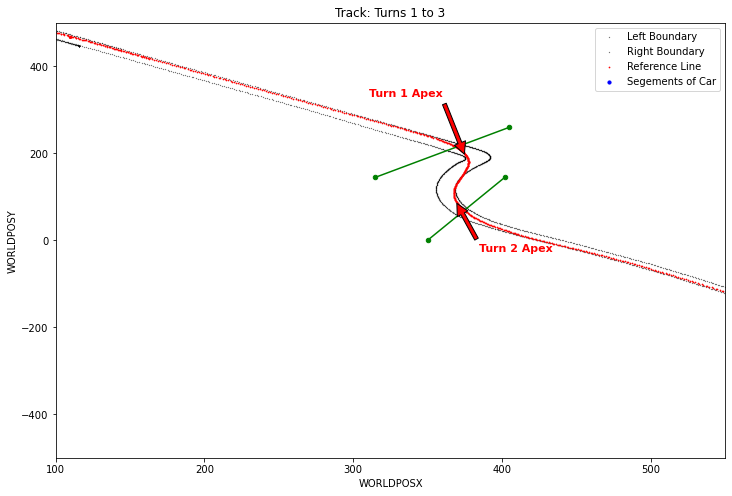

In [5]:
f1_helper.plot_track_with_turns(f1sim_left_df, f1sim_right_df, f1sim_turns, 1, 3, f1sim_line, x_coords=[0,0], y_coords=[0,0])

In [6]:
#------------------------------------------------------------------------------
# LAP_INVALID

combined_right_list = f1sim_right_df[['WORLDPOSX', 'WORLDPOSY']].values.tolist()
combined_left_list = f1sim_left_df[['WORLDPOSX', 'WORLDPOSY']].values.tolist()

lap_validity_dict = {}
for index, row in f1sim_df.iterrows():
    # Access the WORLDPOSX and WORLDPOSY columns directly from row
    position_list = [row['WORLDPOSX'], row['WORLDPOSY']]
    # Calculate the LAP_INVALID_VINCE value using the helper function

    value = f1_helper.is_car_on_track(position_list, combined_left_list, combined_right_list)

    if row["LAP_ID"] not in lap_validity_dict:
        lap_validity_dict[row["LAP_ID"]] = {}

    lap_validity_dict[row["LAP_ID"]][row["FRAME"]] = value

In [8]:
invalid_lap_column = {}
for key in lap_validity_dict:
    sub_dict = lap_validity_dict[key]
    if all(value is True for value in sub_dict.values()):
        invalid_lap_column[key] = 0
    else:
        invalid_lap_column[key] = 1

In [9]:
invalid_lap_column
valid_lap_df = pd.DataFrame(invalid_lap_column.items(), columns=['LAP_ID', 'INVALID_LAP'])

In [9]:
valid_lap_df[valid_lap_df["INVALID_LAP"] == 1]

,LAP_ID,INVALID_LAP
0,1.0046447013921722e+19_1,1
2,1.0046447013921722e+19_3,1
12,1.0395982842815324e+19_2,1
14,1.0454724100726356e+19_2,1
16,1.0596842592410309e+19_1,1
...,...,...
749,9.71939164443773e+18_3,1
750,9.782371720071811e+18_1,1
751,9.782371720071811e+18_2,1
752,9.922655568079577e+18_1,1


In [10]:
valid_lap_df.to_csv(os.path.join(current_dir, '..', 'processed_data', 'f1sim_valid_lap_data.csv'))

### Time Transformations

281.7011936431935
Basic Summary Statistics:
count    294593.000000
mean      14914.262757
std        8097.540801
min       11054.294203
25%       11722.737188
50%       12417.755789
75%       14203.667344
max       74932.326943
Name: finish_time, dtype: float64

Variance: 65570167.02752306
Skewness: 4.7575709484559905


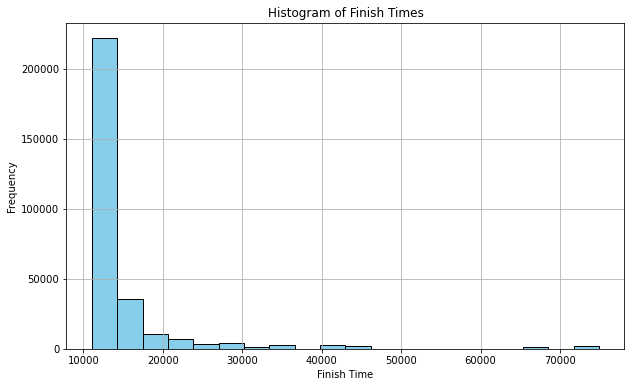

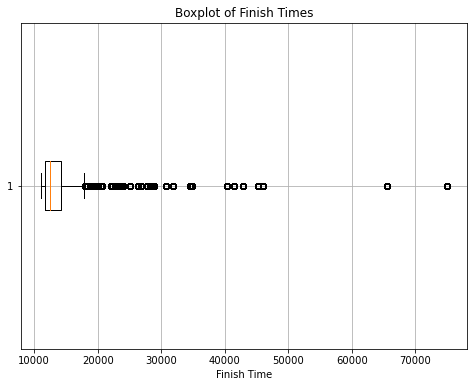

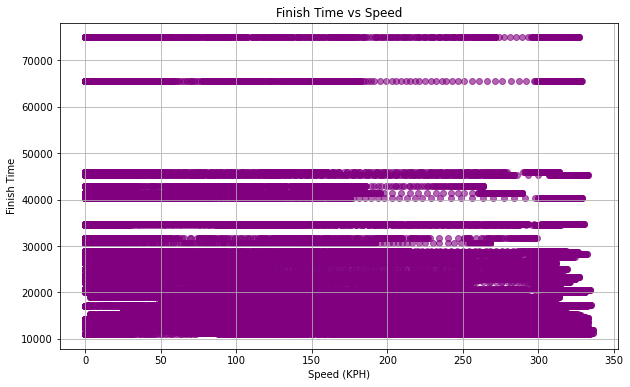

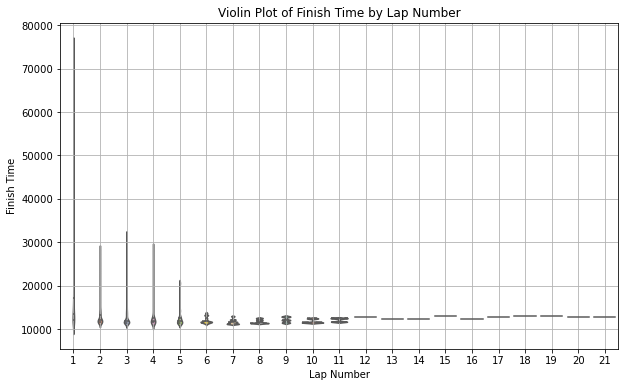

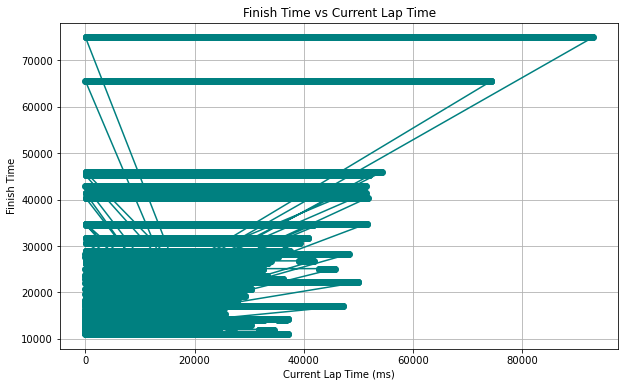

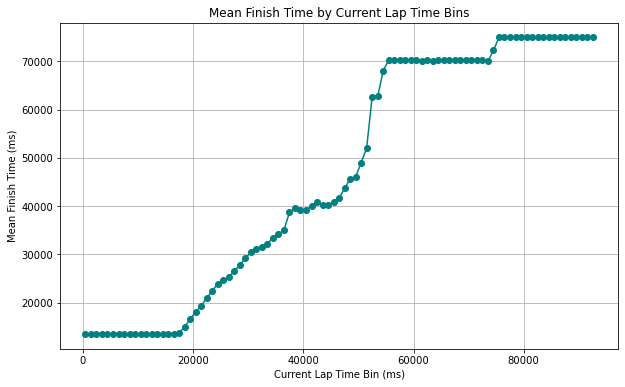

In [11]:
## Time Taken to go to the midpoint of turn 2 and turn 3

def distance_formula(A, B):
    """
        Function takes two coordinates (x,y), outputs straight-line distance between points using distance formula.
        Parameters: Two lists: A and B, each with two elements within them (x,y).
        Returns: Float of the distance
        TC: O(1)
    """
    return math.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2)

### Created new crossing the finish line function based on the math (not too sure if its right)

def interpolate_finish_time_df(df : pd.DataFrame, distance_col: str, time_col : str, lap_col: str, target_distance: int) -> pd.DataFrame:
    """
    Function to estimate when a car crossed the 'finish line' at a specific target distance
    for multiple laps and create a new column with the finish time in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing lap data with columns for lap distances and times.
    - distance_col: The name of the column in df that contains the lap distances (e.g., 'distance')
    - time_col: The name of the column in df that contains the times (e.g., 'time')
    - lap_col: The name of the column in df that contains the lap identifiers (e.g., 'lap_id')
    - target_distance: The target distance (l) where the 'finish line' is located (e.g., 225)

    Returns:
    - df: The input DataFrame with a new column 'finish_time' that contains the interpolated finish times.
    """
    
    # To store finish times for each lap
    finish_times = []

    # Group the DataFrame by lap_col (e.g., lap_id)
    grouped = df.groupby(lap_col)

    # Iterate over each lap group
    for lap_id, lap_data in grouped:
        lap_distances = lap_data[distance_col].values  # Extract the distances for the current lap
        times = lap_data[time_col].values  # Extract the times for the current lap

        # Find the two closest points to the target distance for this lap
        for i in range(len(lap_distances) - 1):
            if lap_distances[i] <= target_distance <= lap_distances[i + 1]:
                # Points found: lap_distances[i] (Lt), lap_distances[i + 1] (Lt+1)
                Lt = lap_distances[i]
                Lt1 = lap_distances[i + 1]
                Tt = times[i]
                Tt1 = times[i + 1]

                # Linear interpolation factor
                c = (Lt1 - target_distance) / (Lt1 - Lt)

                # Interpolate the finish time at the target distance
                finish_time = (1 - c) * Tt + c * Tt1
                finish_times.append((lap_id, finish_time))  # Store the finish time for this lap
                break
        else:
            # If no valid points found within the target distance range, raise an error
            raise ValueError(f"Target distance is outside the range for lap {lap_id}")

    # Convert the finish_times list into a DataFrame
    finish_time_df = pd.DataFrame(finish_times, columns=[lap_col, 'finish_time'])

    # Merge the finish times back into the original DataFrame
    df = df.merge(finish_time_df, on=lap_col, how='left')

    return df

def interpolate_time_of_crossing_unknown_closest(target_dist, point_dist_list, point_times_list):
    """
        Function takes in list of points, then outputs an interpolated time at which the car passed/drove a certain 'distance'.
        Function takes in a list of points, and their associated times.
        Parameters: 
            target_dist (float): Distance of desired target_point.
            point_dist_list (list): List of distances of points
            point_times_list (list): List of corresponding times of points 
                Note: ensure indexes of both lists line up (same index same row!!)
        Returns: Interpolated time at which car passed target distance
        TC: O(n)
        Note!: This function assumes you don't know the closest two points (based on distance).
    """
    if len(point_dist_list) < 2:
        raise ValueError("point_dist_list must contain at least two points.")
    if len(point_times_list) < 2:
        raise ValueError("point_times_list must contain at least two points.")

    #point 1 is larger dist
    #point 2 is smaller dist
    point1 = None
    point1_index = None
    point2 = None
    point2_index = None

    for index, value in enumerate(point_dist_list):
        if value >= target_dist:
            if point1 is None or value < point1:
                point1 = value
                min_larger_index = index
        if value <= target_dist:
            if point2 is None or value > point2:
                point2 = value
                point2_index = index
    if point1 == None or point2 == None:
        raise ValueError("couldn't find applicable point in list")

    return f1_helper.interpolate_time_of_crossing_known_closest(target_dist, point1, point2, point_times_list[point1_index], point_times_list[point2_index])



#Need to load turns.csv data to find the coordinates of turn 2 and turn 3 
df = pd.read_csv(os.path.join(current_dir, '..', 'processed_data', 'f1sim_combined.csv'))
df = df.drop(['Unnamed: 0'], axis=1)
df = df.reset_index(drop=True)
turns = pd.read_csv(os.path.join(current_dir, '..', 'data', 'f1sim-ref-turns.csv'))

#The original dataframe is only between turn 2 and 3 

#Create a midpoint column

turns["MIDPOINT_X"] = (turns.CORNER_X1 + turns.CORNER_X2) / 2 
turns["MIDPOINT_Y"] = (turns.CORNER_Y1 + turns.CORNER_Y2) / 2 

#filter turns csv for only turns 2 and 3 

list = [2,3]
relevant_turns = turns[turns.index.isin(list)].reset_index()

#TODO: Can we consider inserting a diagram? 


#We need to create a 'new' set of coordinates that is the midpoint of turn 2 and 3 
#consider this the half way line between turn 2 and turn 3 

between_turn_x1 = (relevant_turns['CORNER_X1'].values[0] + relevant_turns['CORNER_X1'].values[1]) / 2 
between_turn_y1 = (relevant_turns['CORNER_Y1'].values[0] + relevant_turns['CORNER_Y1'].values[1]) / 2 
between_turn_x2 = (relevant_turns['CORNER_X2'].values[0] + relevant_turns['CORNER_X2'].values[1]) / 2 
between_turn_y2 = (relevant_turns['CORNER_Y2'].values[0] + relevant_turns['CORNER_Y2'].values[1]) / 2 


#Midpoint of the midpoint of turn 2 and 3 

midpoint_x = (between_turn_x1 + between_turn_x2) / 2 
midpoint_y = (between_turn_y1 + between_turn_y2) / 2 

#Calculate the straight line distance between turn 2 midpoint and the halfway line

turn_2_coordinates = (376,72.5)
halfway_line_coordinates = (551,-148.25)

distance = distance_formula(turn_2_coordinates,halfway_line_coordinates)
print(distance)

#turn 2 starts at 515m (FEMKE CALCULATED THIS)

target_distance = 515 + distance


###then use Vince's formula to find the time taken to cross turn 3 
###takes in the target distance which is the distance from the start 
### to the distance to the midpoint 

#extract lap_distance column as a list 
lap_distance_list = df['LAP_DISTANCE'].to_list()

#extract lap_time as a list 

lap_time_list = df['CURRENT_LAP_TIME_MS'].to_list()

#Apply linear interpolation function 

df_with_finish_times = interpolate_finish_time_df(df, 'LAP_DISTANCE', 'CURRENT_LAP_TIME_MS', 'LAP_ID', target_distance)

#Summary Statistics 

summary_stats = df_with_finish_times['finish_time'].describe()
print("Basic Summary Statistics:")
print(summary_stats)

# Variance, skewness, and kurtosis
variance = df_with_finish_times['finish_time'].var()
skewness = df_with_finish_times['finish_time'].skew()

print(f"\nVariance: {variance}")
print(f"Skewness: {skewness}")

#Plots 
plt.figure(figsize=(10, 6))
plt.hist(df_with_finish_times['finish_time'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Finish Times')
plt.xlabel('Finish Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df_with_finish_times['finish_time'].dropna(), vert=False)
plt.title('Boxplot of Finish Times')
plt.xlabel('Finish Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_with_finish_times['SPEED_KPH'], df_with_finish_times['finish_time'], color='purple', alpha=0.6)
plt.title('Finish Time vs Speed')
plt.xlabel('Speed (KPH)')
plt.ylabel('Finish Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='LAP_NUM', y='finish_time', data=df_with_finish_times, inner='quartile', palette='Set2')
plt.title('Violin Plot of Finish Time by Lap Number')
plt.xlabel('Lap Number')
plt.ylabel('Finish Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_with_finish_times['CURRENT_LAP_TIME_MS'], df_with_finish_times['finish_time'], marker='o', linestyle='-', color='teal')
plt.title('Finish Time vs Current Lap Time')
plt.xlabel('Current Lap Time (ms)')
plt.ylabel('Finish Time')
plt.grid(True)
plt.show()

# Create bins for CURRENT_LAP_TIME_MS
bin_size = 1000  # Size of each bin in milliseconds
bins = range(0, int(df_with_finish_times['CURRENT_LAP_TIME_MS'].max()) + bin_size, bin_size)
df_with_finish_times['CURRENT_LAP_TIME_BIN'] = pd.cut(df['CURRENT_LAP_TIME_MS'], bins=bins)

# Calculate the mean finish time for each bin
df_binned_mean = df_with_finish_times.groupby('CURRENT_LAP_TIME_BIN').agg({'finish_time': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
# Use the mid value of each bin for plotting
plt.plot(df_binned_mean['CURRENT_LAP_TIME_BIN'].apply(lambda x: x.mid), df_binned_mean['finish_time'], marker='o', linestyle='-', color='teal')
plt.title('Mean Finish Time by Current Lap Time Bins')
plt.xlabel('Current Lap Time Bin (ms)')
plt.ylabel('Mean Finish Time (ms)')
plt.grid(True)
plt.show()


In [12]:
df_with_finish_times["TIME_TO_END_LINE_S"] = df_with_finish_times["finish_time"] / 1000

In [13]:
time_df = df_with_finish_times[["LAP_ID", "TIME_TO_END_LINE_S"]]

time_df = time_df.drop_duplicates()
time_df.reset_index(drop=True)


,LAP_ID,TIME_TO_END_LINE_S
0,1.0046447013921722e+19_1,12.476936
1,1.0046447013921722e+19_2,11.829431
2,1.0046447013921722e+19_3,11.752042
3,1.020389177761665e+19_1,11.424535
4,1.020389177761665e+19_2,11.388881
...,...,...
749,9.71939164443773e+18_3,13.862388
750,9.782371720071811e+18_1,17.953059
751,9.782371720071811e+18_2,12.015733
752,9.922655568079577e+18_1,14.145148


### Segment Features (in the turns)

See the SegmentedFeatures for derivation of the segment features. 

In [14]:
segment_df = pd.read_csv(os.path.join(current_dir, '..', 'processed_data', 'f1sim_segment_data.csv'))
segment_df = segment_df.drop(['Unnamed: 0'], axis=1)
segment_df = segment_df.drop(["INDEX"], axis=1)
segment_df = segment_df.reset_index(drop=True)

# **Braking Features**
Distance when car begins braking, reaches peak braking level in that instance and finally the distance when stopped braking.

- This reveals the braking patterns and distances at which they occured for each session and lap.

- We consider a braking event based on a threshold. If Braking level exceeds threshold of 0.1 we consider this to be a braking event

In [15]:
def create_braking_events(df, brake_threshold=0.1):
    braking_events = []  # To store each braking event as a separate row
    
    # Iterate over each session and lap
    for session_id, session_data in df.groupby('SESSION_IDENTIFIER'):
        for lap_num, lap_data in session_data.groupby('LAP_NUM'):
            
            # Initialise variables to track a braking event
            braking = False
            brake_start = np.nan
            peak_brake_value = 0
            brake_peak_distance = np.nan
            brake_end = np.nan
            
            # Iterate over the rows in lap_data
            for i, row in lap_data.iterrows():
                if not braking and row['BRAKE'] > brake_threshold:
                    # Braking starts
                    braking = True
                    brake_start = row['LAP_DISTANCE']
                    peak_brake_value = row['BRAKE']
                    brake_peak_distance = row['LAP_DISTANCE']
                    
                elif braking:
                    if row['BRAKE'] > peak_brake_value:
                        # Update peak brake value and distance
                        peak_brake_value = row['BRAKE']
                        brake_peak_distance = row['LAP_DISTANCE']
                        
                    if row['BRAKE'] <= brake_threshold:
                        # Braking ends
                        braking = False
                        brake_end = row['LAP_DISTANCE']
                        
                        # Store the braking event
                        braking_events.append({
                            'SESSION_IDENTIFIER': session_id,
                            'LAP_NUM': lap_num,
                            'LAP_ID' : row['LAP_ID'],
                            'BRAKE_START': brake_start,
                            'BRAKE_PEAK': brake_peak_distance,
                            'BRAKE_END': brake_end
                        })
    
    # Create a new DataFrame to store all braking events and sort by session and lap
    braking_events_df = pd.DataFrame(braking_events).sort_values(by=['SESSION_IDENTIFIER', 'LAP_NUM'], ascending=[False, True])

    return braking_events_df

# Apply the braking event function
braking_events_df = create_braking_events(f1sim_df)

# Check output 
print(braking_events_df.head(20))

      SESSION_IDENTIFIER  LAP_NUM                    LAP_ID  BRAKE_START  \
1231        1.839489e+19        1  1.8394889979533148e+19_1   302.844055   
1232        1.839489e+19        2  1.8394889979533148e+19_2   274.673340   
1233        1.839489e+19        2  1.8394889979533148e+19_2   444.087402   
1234        1.839489e+19        2  1.8394889979533148e+19_2   451.222168   
1229        1.822200e+19        1  1.8221996462328779e+19_1   284.683594   
1230        1.822200e+19        2  1.8221996462328779e+19_2   281.185059   
1223        1.797894e+19        1  1.7978944179730821e+19_1   296.787292   
1224        1.797894e+19        1  1.7978944179730821e+19_1   357.726624   
1225        1.797894e+19        2  1.7978944179730821e+19_2   272.620605   
1226        1.797894e+19        3  1.7978944179730821e+19_3   269.485352   
1227        1.797894e+19        3  1.7978944179730821e+19_3   368.137695   
1228        1.797894e+19        3  1.7978944179730821e+19_3   374.800781   
1220        

In [16]:
# Function takes dataframe above (all braking events) and takes first braking instance before t1, (defined as 180 - 300).
# Function DOES isolate each LAP_ID, so there is one row per LAP_ID.
# Function DOES NOT combine this information with f1sim_df!
# Function PRINTS output!!! PLEASE REMOVE BEFORE PROCESSING!!


def isolate_first_braking_start_before_t1(df):
   filtered_df = df[(df['BRAKE_START'] <= 350) & (df['BRAKE_START'] >= 180)]
   filtered_df = filtered_df.drop_duplicates(subset='LAP_ID', keep='first').reset_index(drop=True)
   filtered_df = filtered_df[["LAP_ID", "BRAKE_START"]]


   return filtered_df


braking_dataframe = isolate_first_braking_start_before_t1(braking_events_df)
print(braking_dataframe)


                       LAP_ID  BRAKE_START
0    1.8394889979533148e+19_1   302.844055
1    1.8394889979533148e+19_2   274.673340
2    1.8221996462328779e+19_1   284.683594
3    1.8221996462328779e+19_2   281.185059
4    1.7978944179730821e+19_1   296.787292
..                        ...          ...
742    9.71858316376882e+16_1   247.062958
743    9.71858316376882e+16_2   267.701172
744    9.71858316376882e+16_3   270.492188
745   5.892041857252208e+16_1   264.494629
746   5.892041857252208e+16_2   200.608887

[747 rows x 2 columns]


# **Throttle Features**
Distance when car begins throttle, peaks and ends throttle. 

Similar to braking above, we will consider a threshold for a throttle event. For now, consider a threshold of 0.1.

In [17]:
def create_throttle_events(df, throttle_threshold=0.1):
    throttle_events = []

    for session_id, session_data in df.groupby('SESSION_IDENTIFIER'):
        for lap_num, lap_data in session_data.groupby('LAP_NUM'):
            
            # Initialise variables to track a throttle event
            throttle = False
            throttle_start = np.nan 
            peak_throttle_value = 0
            throttle_peak = np.nan 
            throttle_end = np.nan 

            # iterate over the rows in the lap_data
            for i, row in lap_data.iterrows():
                if not throttle and row['THROTTLE'] > throttle_threshold:
                    # Throttle event starts
                    throttle = True
                    throttle_start = row['LAP_DISTANCE']
                    peak_throttle_value = row['THROTTLE']
                    throttle_peak = row['LAP_DISTANCE']

                elif throttle:
                    if row['THROTTLE'] > peak_throttle_value:
                        # Update peak throttle value and distance 
                        peak_throttle_value = row['THROTTLE']
                        throttle_peak = row['LAP_DISTANCE']

                    if row['THROTTLE'] <= throttle_threshold:
                        # Throttle event ends
                        throttle = False 
                        throttle_end = row['LAP_DISTANCE']

                        # Store the throttle event
                        throttle_events.append({
                                'SESSION_IDENTIFIER' : session_id,
                                'LAP_NUM' : lap_num,
                                'LAP_ID' : row['LAP_ID'],
                                'THROTTLE_START' : throttle_start,
                                'THROTTLE_PEAK' : throttle_peak,
                                'THROTTLE_END' : throttle_end
                        })
                        
    # Create a new DataFrame to store all throttle events and sort by session and lap
    throttle_events_df = pd.DataFrame(throttle_events).sort_values(by=['SESSION_IDENTIFIER', 'LAP_NUM'], ascending=[False, True])

    return throttle_events_df

# Apply this throttle event function
create_throttle_events_df = create_throttle_events(f1sim_df)

# Check output
print(create_throttle_events_df.head(20))


      SESSION_IDENTIFIER  LAP_NUM                    LAP_ID  THROTTLE_START  \
1433        1.839489e+19        1  1.8394889979533148e+19_1        1.230851   
1434        1.839489e+19        2  1.8394889979533148e+19_2        0.910645   
1435        1.839489e+19        2  1.8394889979533148e+19_2      365.238281   
1436        1.839489e+19        2  1.8394889979533148e+19_2      451.198730   
1431        1.822200e+19        1  1.8221996462328779e+19_1        3.130463   
1432        1.822200e+19        2  1.8221996462328779e+19_2        0.080566   
1426        1.797894e+19        1  1.7978944179730821e+19_1        0.653209   
1427        1.797894e+19        2  1.7978944179730821e+19_2        2.947266   
1428        1.797894e+19        2  1.7978944179730821e+19_2      377.854980   
1429        1.797894e+19        3  1.7978944179730821e+19_3        3.762695   
1430        1.797894e+19        3  1.7978944179730821e+19_3      351.369141   
1423        1.796284e+19        1  1.796284406003070

In [18]:
# Function takes dataframe above (all throttle events) and takes first throttle instance between t1 and t2, (defined as 240m - 550m).
# Function DOES isolate each LAP_ID, so there is one row per LAP_ID.
# Function DOES NOT combine this information with f1sim_df!
# Function PRINTS output!!! PLEASE REMOVE BEFORE PROCESSING!!


def isolate_first_throttle_start_between_t1_and_t2(df):
   filtered_df = df[(df['THROTTLE_START'] >= 240) & (df['THROTTLE_START'] <= 550)]
   filtered_df = filtered_df.drop_duplicates(subset='LAP_ID', keep='first').reset_index(drop=True)
   filtered_df = filtered_df[["LAP_ID", "THROTTLE_START"]]


   return filtered_df


throttle_dataframe = isolate_first_throttle_start_between_t1_and_t2(create_throttle_events_df)


print(throttle_dataframe)

                       LAP_ID  THROTTLE_START
0    1.8394889979533148e+19_2      365.238281
1    1.7978944179730821e+19_2      377.854980
2    1.7978944179730821e+19_3      351.369141
3    1.7929263176997423e+19_1      359.254456
4    1.7849857623809577e+19_6      384.353516
..                        ...             ...
288   5.084505255730185e+17_1      340.414459
289   3.323344510728646e+17_1      370.373260
290  1.8072678748159776e+17_1      276.069916
291  1.8072678748159776e+17_2      360.449219
292   5.892041857252208e+16_2      291.908203

[293 rows x 2 columns]


In [19]:
laps_df = pd.DataFrame(f1sim_df["LAP_ID"].unique(), columns=["LAP_ID"])

In [20]:
throttle_df = laps_df.merge(throttle_dataframe, on="LAP_ID", how='outer')
brake_df = laps_df.merge(braking_dataframe, on="LAP_ID", how='outer')

In [21]:
throttle_df.merge(brake_df, on=["LAP_ID"], how='inner')

,LAP_ID,THROTTLE_START,BRAKE_START
0,1.0046447013921722e+19_1,347.802185,268.961945
1,1.0046447013921722e+19_2,350.394043,265.546387
2,1.0046447013921722e+19_3,NaN,264.288086
3,1.020389177761665e+19_1,NaN,257.531433
4,1.020389177761665e+19_2,NaN,269.582520
...,...,...,...
749,9.71939164443773e+18_3,354.063477,258.041016
750,9.782371720071811e+18_1,NaN,244.589645
751,9.782371720071811e+18_2,360.333984,257.118164
752,9.922655568079577e+18_1,372.898224,291.980743


## Combined Feature Table

In [22]:
combined_df = throttle_df.merge(brake_df, on=["LAP_ID"], how='inner')
combined_df = combined_df.merge(segment_df, on=["LAP_ID"], how='inner')
combined_df = combined_df.merge(valid_lap_df, on=['LAP_ID'], how='inner')
combined_df = combined_df.merge(time_df, on=['LAP_ID'], how='inner')

In [23]:
combined_df

,LAP_ID,THROTTLE_START,BRAKE_START,BRAKE_STRAIGHTSEGMENT1,THROTTLE_STRAIGHTSEGMENT1,STEERING_STRAIGHTSEGMENT1,SPEED_KPH_STRAIGHTSEGMENT1,DISTANCE_FROM_REFLINE_STRAIGHTSEGMENT1,DISTANCE_FROM_LEFT_STRAIGHTSEGMENT1,DISTANCE_FROM_RIGHT_STRAIGHTSEGMENT1,...,BRAKE_TURN2APEXSEGMENT10,THROTTLE_TURN2APEXSEGMENT10,STEERING_TURN2APEXSEGMENT10,SPEED_KPH_TURN2APEXSEGMENT10,DISTANCE_FROM_REFLINE_TURN2APEXSEGMENT10,DISTANCE_FROM_LEFT_TURN2APEXSEGMENT10,DISTANCE_FROM_RIGHT_TURN2APEXSEGMENT10,LAP_DISTANCE_TURN2APEXSEGMENT10,INVALID_LAP,TIME_TO_END_LINE_S
0,1.0046447013921722e+19_1,347.802185,268.961945,0.000000,0.962173,0.005264,309.0,1.100726,-2.786185,-11.592266,...,0.000000,0.281498,0.174639,163.0,0.658701,-5.448883,11.123008,358.252197,1,12.476936
1,1.0046447013921722e+19_2,350.394043,265.546387,0.000000,1.000000,-0.004257,315.0,-0.453970,2.141060,12.210894,...,0.000000,0.349783,0.223438,159.0,-1.831765,-8.513699,8.115920,359.684570,0,11.829431
2,1.0046447013921722e+19_3,NaN,264.288086,0.000000,1.000000,0.005814,316.0,0.167051,1.850105,-12.588589,...,0.000000,0.920165,0.134813,162.0,-1.561846,8.329156,-8.310633,359.980469,1,11.752042
3,1.020389177761665e+19_1,NaN,257.531433,0.000000,0.976471,0.002251,324.0,-0.256447,1.939222,-12.509152,...,0.121569,0.019608,0.277600,151.0,-0.623902,-7.372500,-9.270131,360.076752,0,11.424535
4,1.020389177761665e+19_2,NaN,269.582520,0.000000,1.000000,0.001335,324.0,0.657918,-2.344151,12.018500,...,0.976471,0.000000,0.321393,167.0,-0.046494,6.566747,-10.054263,359.473145,0,11.388881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,9.71939164443773e+18_3,354.063477,258.041016,0.003983,1.000000,-0.011490,330.0,0.444028,-2.129865,12.240697,...,0.062898,0.163806,0.299977,155.0,0.814431,7.683674,8.969581,360.402344,1,13.862388
750,9.782371720071811e+18_1,NaN,244.589645,0.133074,0.000000,-0.000687,281.0,0.223271,-1.908652,-12.471050,...,0.763470,0.000000,0.040696,171.0,2.681409,3.262011,-13.296847,357.984009,1,17.953059
751,9.782371720071811e+18_2,360.333984,257.118164,0.000000,1.000000,-0.018357,329.0,-0.153643,1.841155,-12.505534,...,0.063035,0.024262,0.232136,158.0,0.143253,-5.977396,10.593516,358.220215,1,12.015733
752,9.922655568079577e+18_1,372.898224,291.980743,0.000000,0.398413,0.002701,251.0,-0.431949,2.119088,12.232247,...,0.000000,0.000000,0.159533,202.0,2.960515,-9.713586,6.917570,359.712372,1,14.145148


In [24]:
combined_df.to_csv(os.path.join(current_dir, '..', '', 'data.csv'))